# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE590-03 Fall 2020

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# test=torch.FloatTensor(2, 3).uniform_(-1, 1)
# print(test)
# test2=torch.FloatTensor(test.shape).uniform_(-1, 1)
# print(test2)
# print(test2+test)
# test3=torch.FloatTensor(test2)
# print(test3)

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [4]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

In [5]:
## Pick a model architecture

net = models.NetA().to(device)
# net = models.NetB().to(device)

## Checkpoint name for this model

model_checkpoint = "netA_standard.pt"
# model_checkpoint = "netB_standard.pt"

## Basic training params

num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop

for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

KeyboardInterrupt: 

**Visualize some perturbed samples**

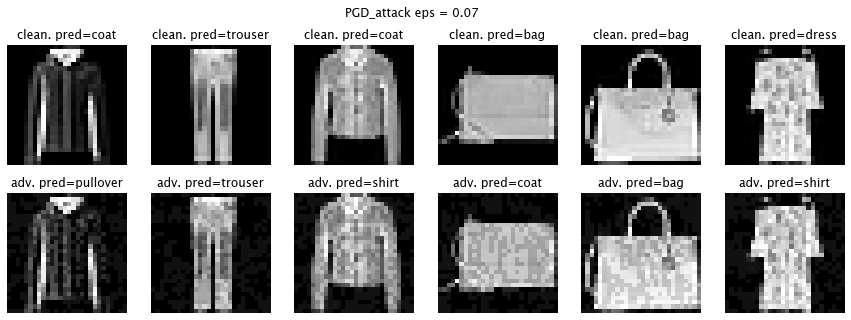

In [6]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
EPSlist=[0.1,0.2,0.3]
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        EPS= 0.07
        ITS=10
        ALP = 1.85*(EPS/ITS)
        adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps=EPS)
#         adv_data = attacks.PGD_attack(net,device,data.clone().detach(),labels,eps=EPS,alpha=ALP,iters=ITS,rand_start=True)
        ###
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
       
        plt.figure(figsize=(15,5))
        plt.suptitle("PGD_attack eps = {}".format(EPS))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
#         plt.tight_layout()
        plt.show()
        break

## Test Attacks - Whitebox & Blackbox

In [ ]:
## Load pretrained models



## Test the models against an adversarial attack

epslist=np.linspace(0,0.1,11)

# TODO: Set attack parameters here
wbacc=[]
bbacc=[]


for ATK_EPS in epslist:
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt"))
    blackbox.load_state_dict(torch.load("netB_standard.pt"))

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)
    ATK_ITERS =10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

    # TODO: Perform adversarial attack here
        adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps=ATK_EPS)
#         adv_data = attacks.PGD_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS,alpha=ATK_ALPHA,iters=ATK_ITERS ,rand_start=True)

    # Sanity checking if adversarial example is "legal"

        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
        with torch.no_grad():
        # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
        # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
    
    # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

# Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total
    wbacc.append(whitebox_acc)
    bbacc.append(blackbox_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    print("Done!")


Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


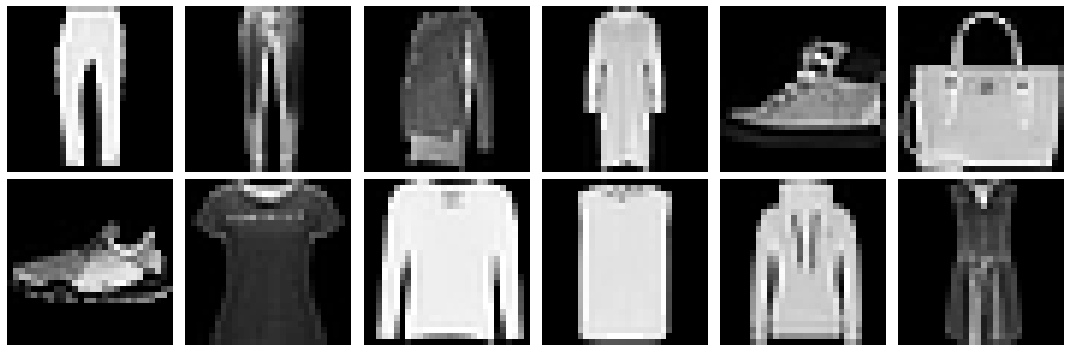

Attack Epsilon: 0.0; Whitebox Accuracy: 0.921; Blackbox Accuracy: 0.9225
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


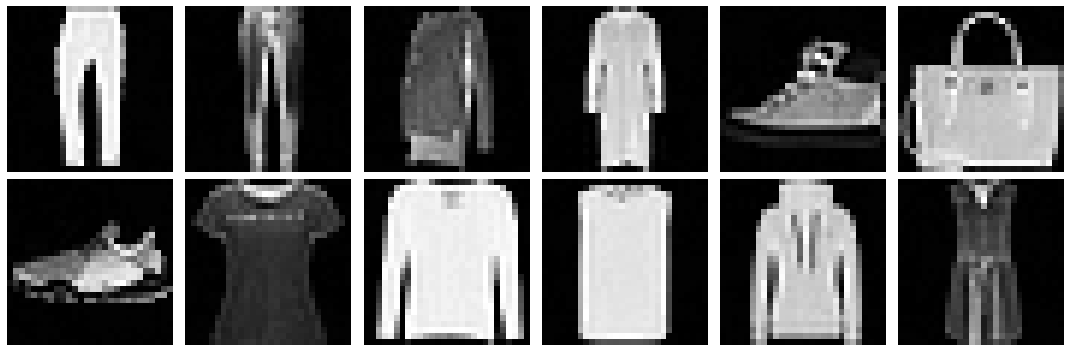

Attack Epsilon: 0.01; Whitebox Accuracy: 0.6789; Blackbox Accuracy: 0.8812
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


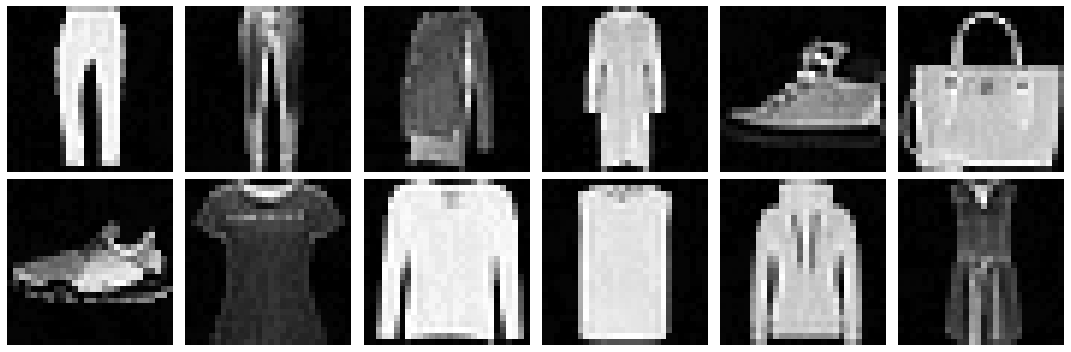

Attack Epsilon: 0.02; Whitebox Accuracy: 0.4617; Blackbox Accuracy: 0.8153
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


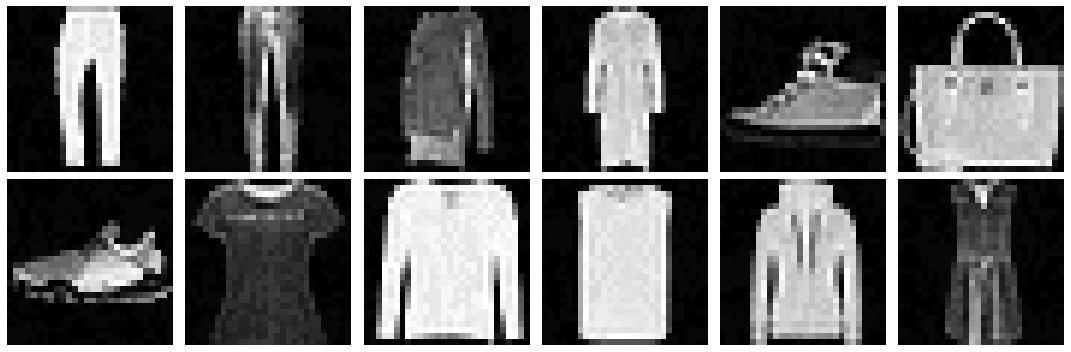

Attack Epsilon: 0.03; Whitebox Accuracy: 0.3315; Blackbox Accuracy: 0.7485
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


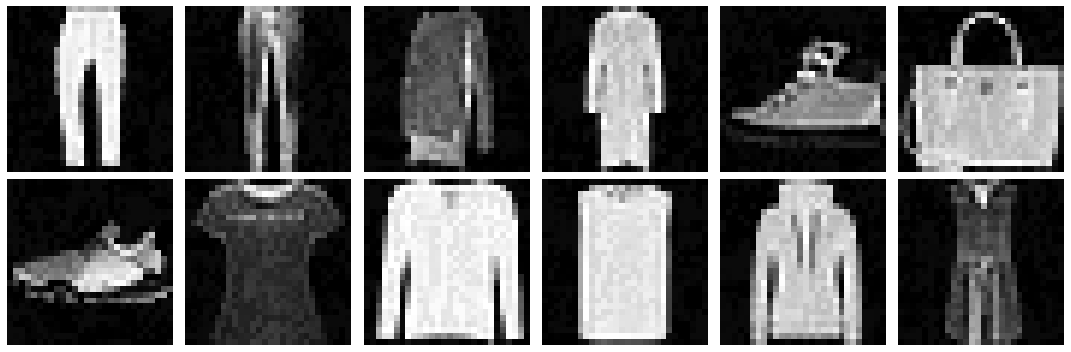

Attack Epsilon: 0.04; Whitebox Accuracy: 0.2385; Blackbox Accuracy: 0.6716
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


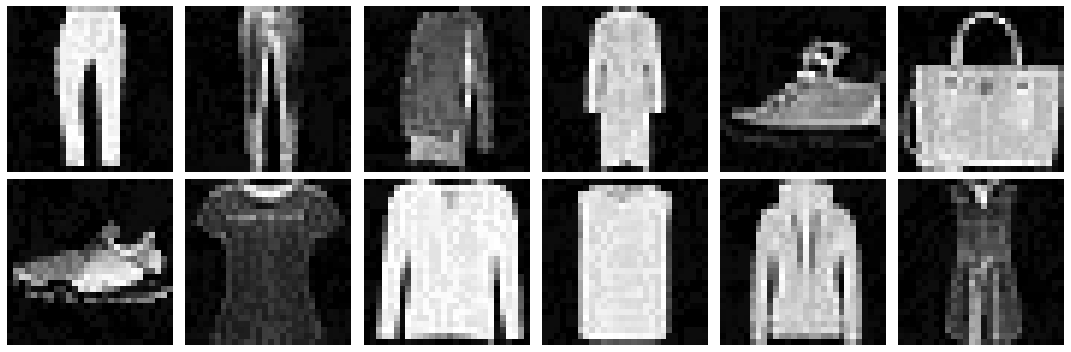

Attack Epsilon: 0.05; Whitebox Accuracy: 0.1656; Blackbox Accuracy: 0.6014
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


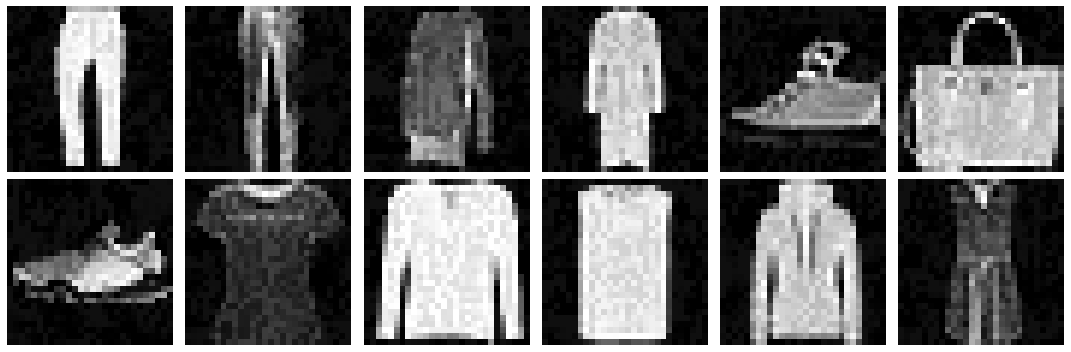

Attack Epsilon: 0.06; Whitebox Accuracy: 0.1095; Blackbox Accuracy: 0.5249
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


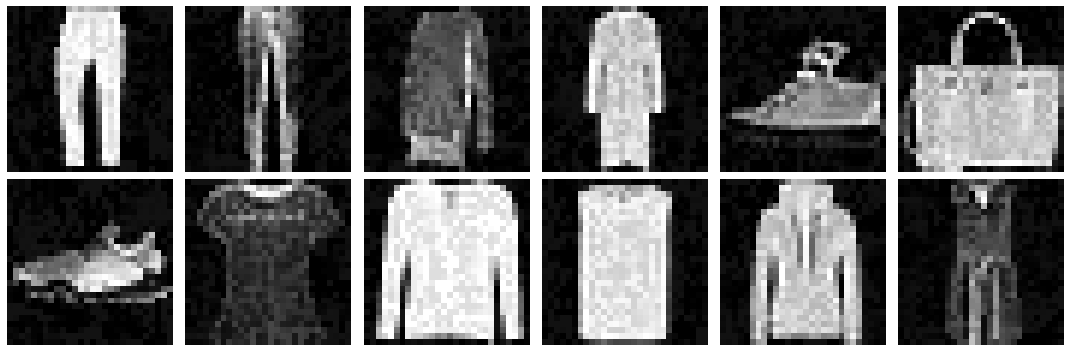

Attack Epsilon: 0.07; Whitebox Accuracy: 0.0766; Blackbox Accuracy: 0.4639
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


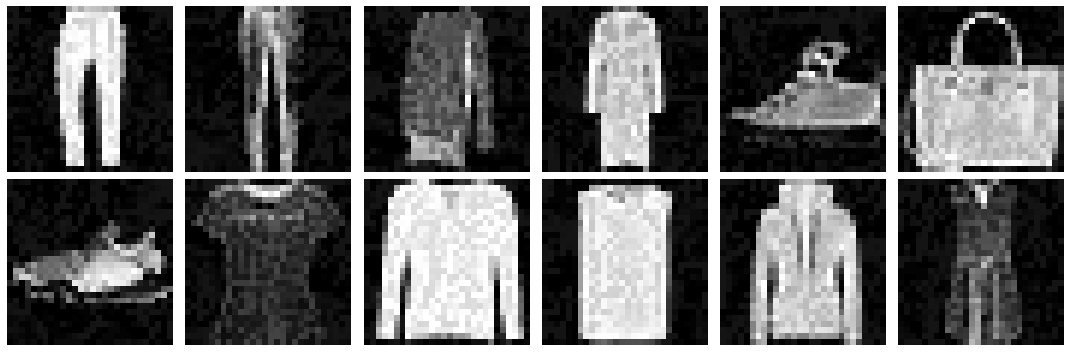

Attack Epsilon: 0.08; Whitebox Accuracy: 0.051; Blackbox Accuracy: 0.3985
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


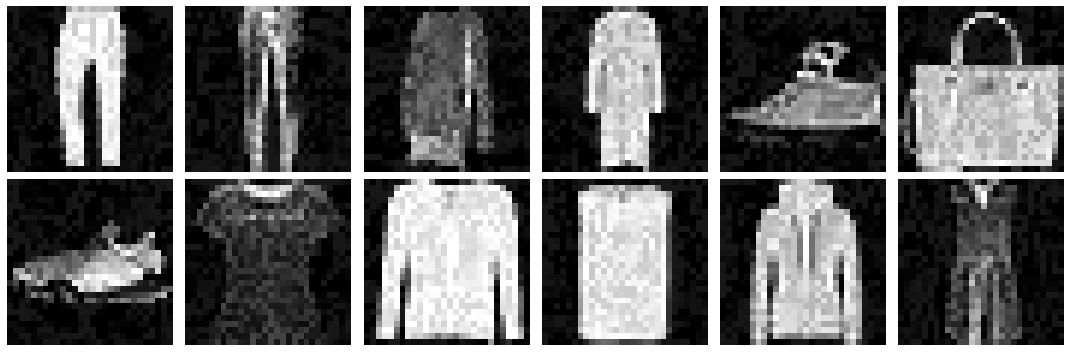

Attack Epsilon: 0.09; Whitebox Accuracy: 0.0329; Blackbox Accuracy: 0.3497
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


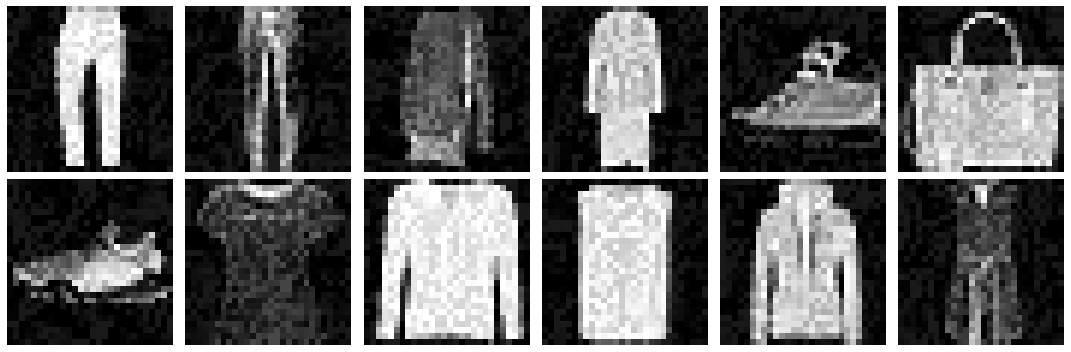

Attack Epsilon: 0.1; Whitebox Accuracy: 0.023; Blackbox Accuracy: 0.3051
Done!


In [10]:
wbaccPGD=[]
bbaccPGD=[]


for ATK_EPS in epslist:
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt"))
    blackbox.load_state_dict(torch.load("netB_standard.pt"))

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)
    ATK_ITERS =10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

    # TODO: Perform adversarial attack here
#         adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps=ATK_EPS)
        adv_data = attacks.PGD_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS,alpha=ATK_ALPHA,iters=ATK_ITERS ,rand_start=True)

    # Sanity checking if adversarial example is "legal"

        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
        with torch.no_grad():
        # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
        # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
    
    # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

# Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total
    wbaccPGD.append(whitebox_acc)
    bbaccPGD.append(blackbox_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    print("Done!")

Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


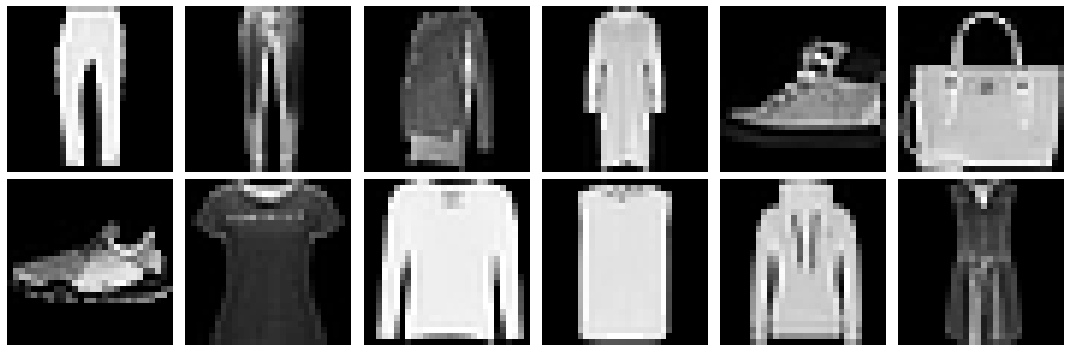

Attack Epsilon: 0.0; Whitebox Accuracy: 0.921; Blackbox Accuracy: 0.9225
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


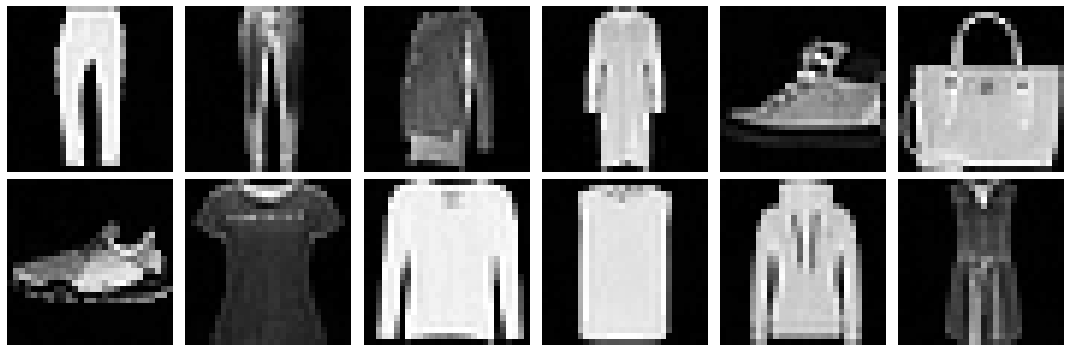

Attack Epsilon: 0.01; Whitebox Accuracy: 0.6689; Blackbox Accuracy: 0.8772
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


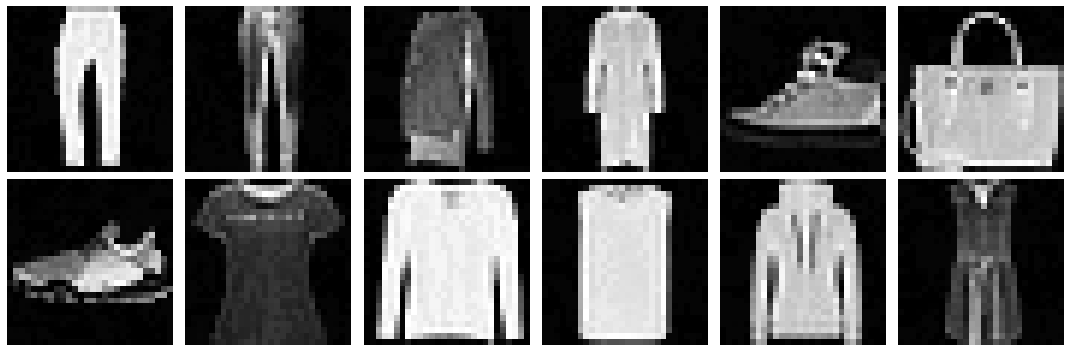

Attack Epsilon: 0.02; Whitebox Accuracy: 0.4484; Blackbox Accuracy: 0.8065
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


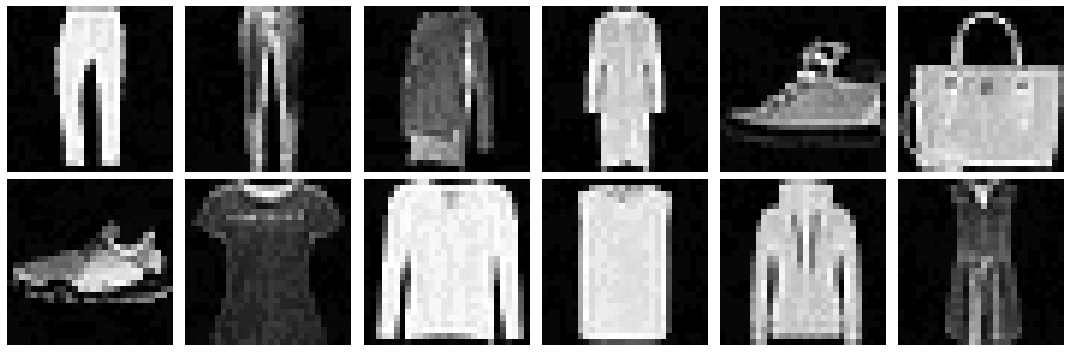

Attack Epsilon: 0.03; Whitebox Accuracy: 0.3187; Blackbox Accuracy: 0.7298
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


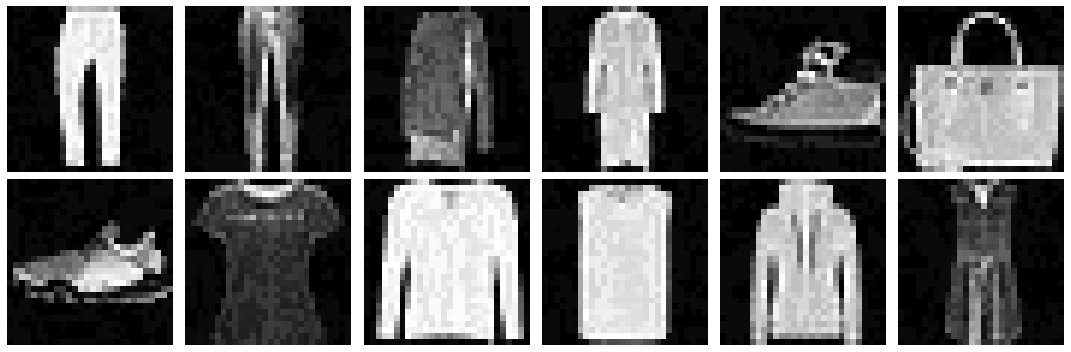

Attack Epsilon: 0.04; Whitebox Accuracy: 0.2225; Blackbox Accuracy: 0.6525
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


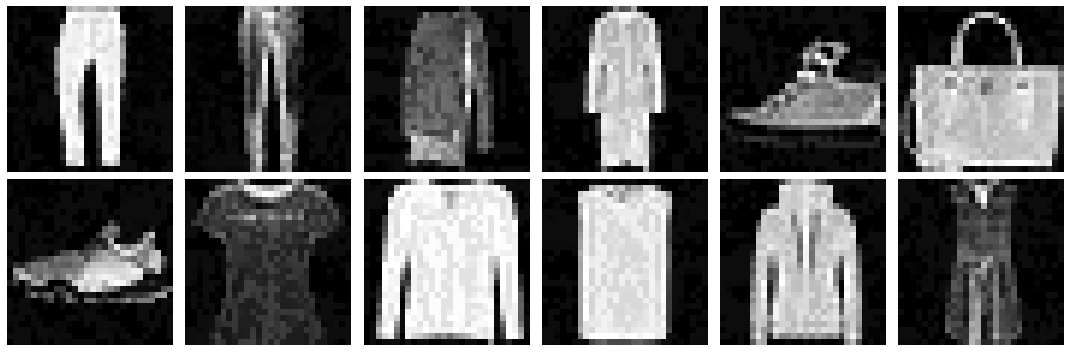

Attack Epsilon: 0.05; Whitebox Accuracy: 0.1535; Blackbox Accuracy: 0.5729
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


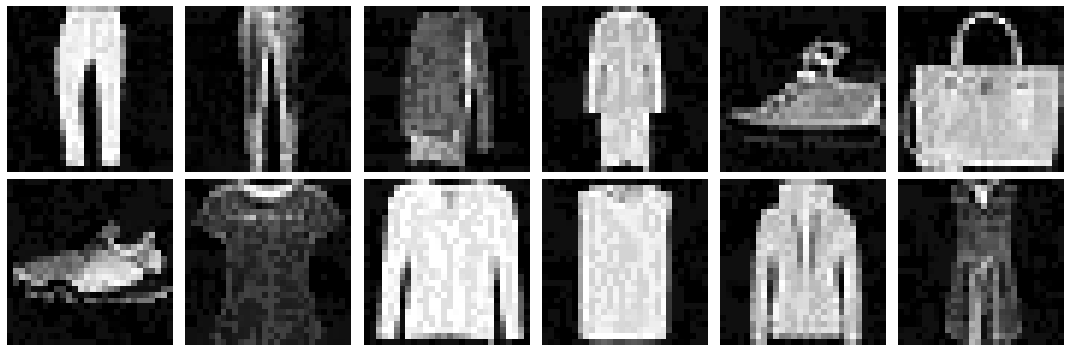

Attack Epsilon: 0.06; Whitebox Accuracy: 0.1081; Blackbox Accuracy: 0.4935
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


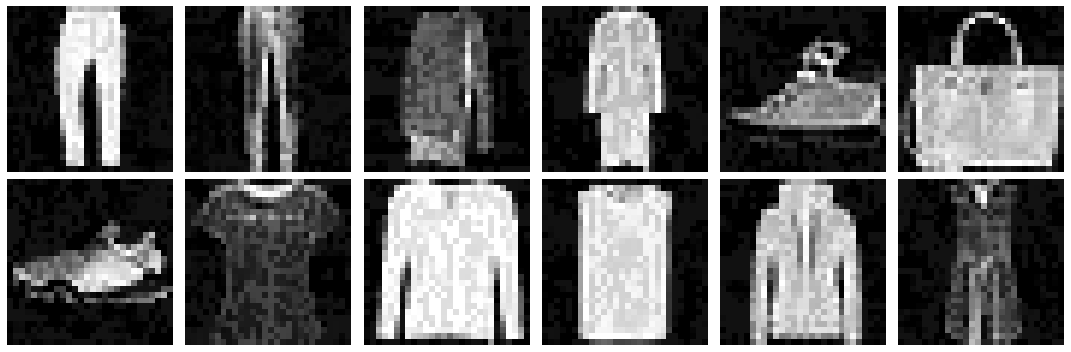

Attack Epsilon: 0.07; Whitebox Accuracy: 0.0757; Blackbox Accuracy: 0.4214
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


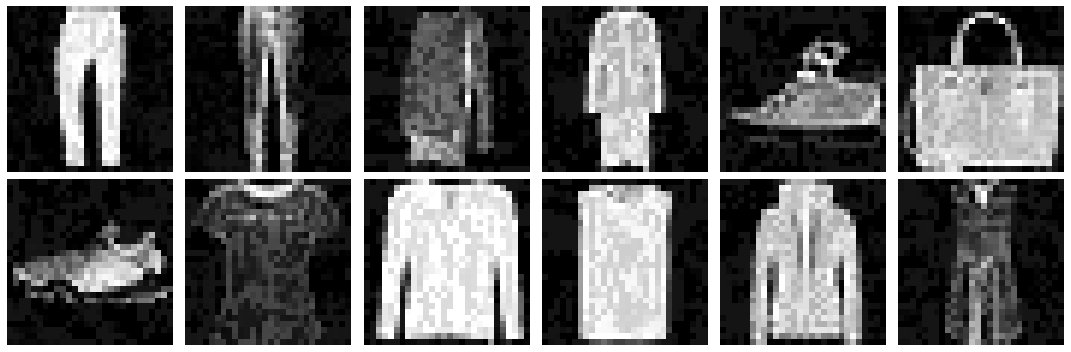

Attack Epsilon: 0.08; Whitebox Accuracy: 0.0546; Blackbox Accuracy: 0.3606
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


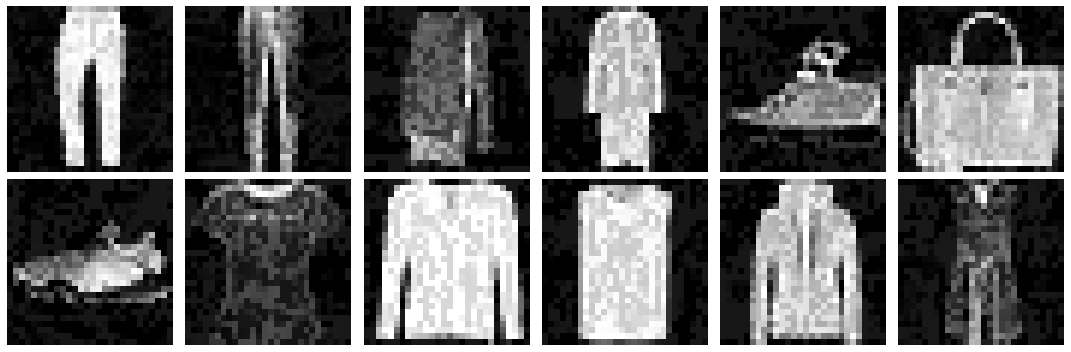

Attack Epsilon: 0.09; Whitebox Accuracy: 0.0389; Blackbox Accuracy: 0.3082
Done!
Initial Accuracy of Whitebox Model:  0.921
Initial Accuracy of Blackbox Model:  0.9225


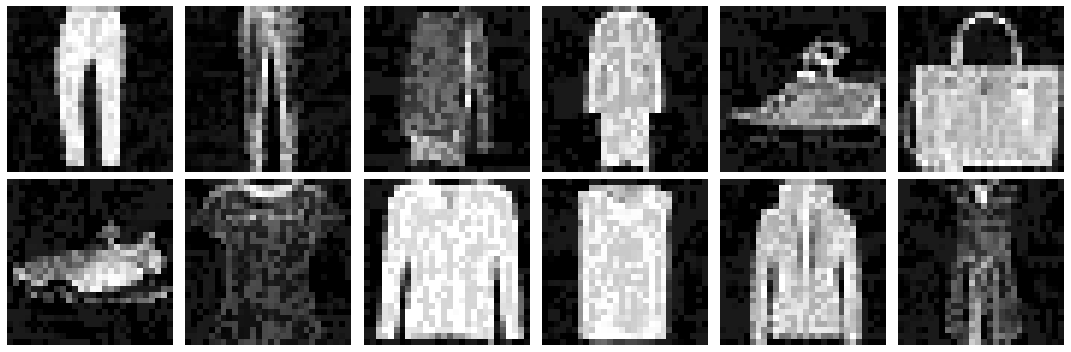

Attack Epsilon: 0.1; Whitebox Accuracy: 0.0291; Blackbox Accuracy: 0.2651
Done!


In [8]:
wbaccMu=[]
bbaccMu=[]
epslist=np.linspace(0,0.1,11)

for ATK_EPS in epslist:
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt"))
    blackbox.load_state_dict(torch.load("netB_standard.pt"))

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)
    ATK_ITERS =10
    ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

    # TODO: Perform adversarial attack here
#         adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps=ATK_EPS)
        adv_data = attacks.MomentumIterative_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS,alpha=ATK_ALPHA,iters=ATK_ITERS ,mu=1.0)

    # Sanity checking if adversarial example is "legal"

        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
        with torch.no_grad():
        # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
        # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)
    
    # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

# Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total
    wbaccMu.append(whitebox_acc)
    bbaccMu.append(blackbox_acc)
    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    print("Done!")

In [ ]:

# plt.figure(figsize=(18,6))
# plt.title("white_box Accuracy vs eps")
# plt.plot(epslist,wbacc, color='b',label='FGSM_attack')
# plt.plot(epslist,wbaccPGD, color='r',label='PGD_attack')
# plt.xlabel('eps')
# plt.ylabel("Acc")
# plt.legend()
# plt.show()


plt.figure(figsize=(18,6))
plt.title("black_box Accuracy vs eps")
plt.plot(epslist,bbacc, color='b',label='FGSM_attack')
plt.plot(epslist,bbaccPGD, color='r',label='PGD_attack')
plt.xlabel('eps')
plt.ylabel("Acc")
plt.legend()
plt.show()

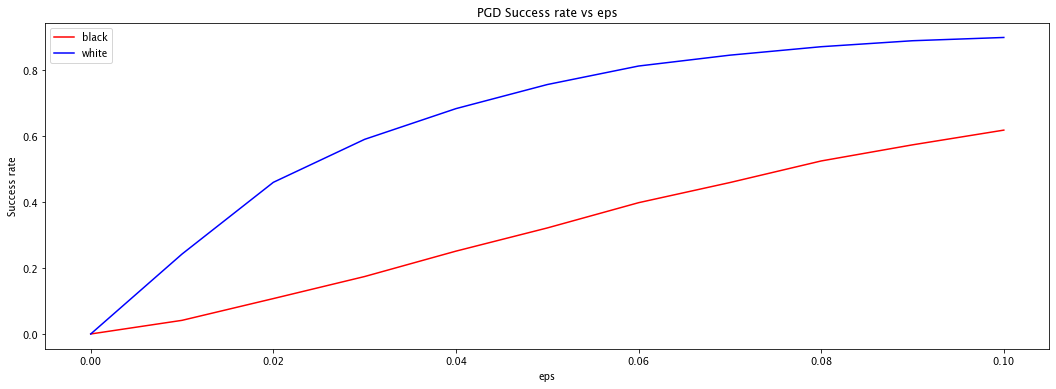

NameError: name 'wbacc' is not defined

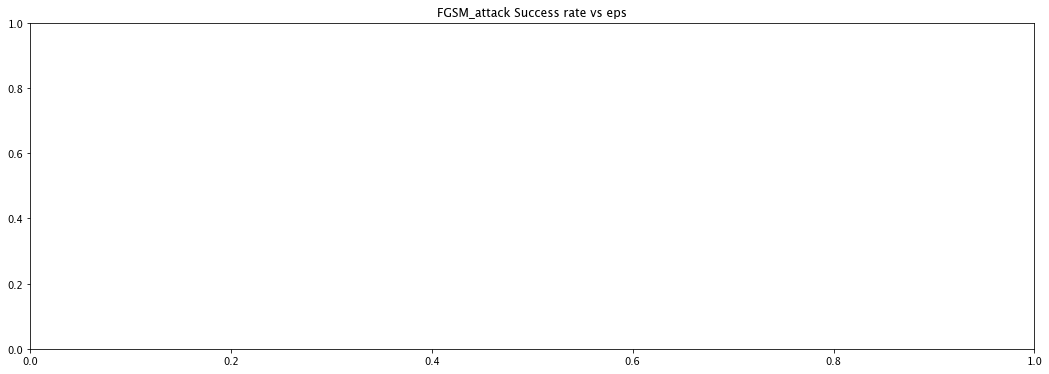

In [14]:
whitebox = models.NetA()
blackbox = models.NetB()

whitebox.load_state_dict(torch.load("netA_standard.pt"))
blackbox.load_state_dict(torch.load("netB_standard.pt"))

whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
whitebox.eval(); blackbox.eval()

wtest_acc,_ = test_model(whitebox,test_loader,device)
btest_acc,_ = test_model(blackbox,test_loader,device)


plt.figure(figsize=(18,6))
plt.title("PGD Success rate vs eps")

plt.plot(epslist,btest_acc*np.ones(len(bbaccPGD))-bbaccPGD, color='r',label='black')
plt.plot(epslist,wtest_acc*np.ones(len(wbaccPGD))-wbaccPGD, color='b',label='white')
plt.xlabel('eps')
plt.ylabel("Success rate")
plt.legend()
plt.show()


plt.figure(figsize=(18,6))
plt.title("FGSM_attack Success rate vs eps")
plt.plot(epslist,wtest_acc*np.ones(len(wbacc))-wbacc, color='b',label='white')
plt.plot(epslist,btest_acc*np.ones(len(bbacc))-bbacc, color='r',label='black')

plt.xlabel('eps')
plt.ylabel("Success rate")
plt.legend()
plt.show()

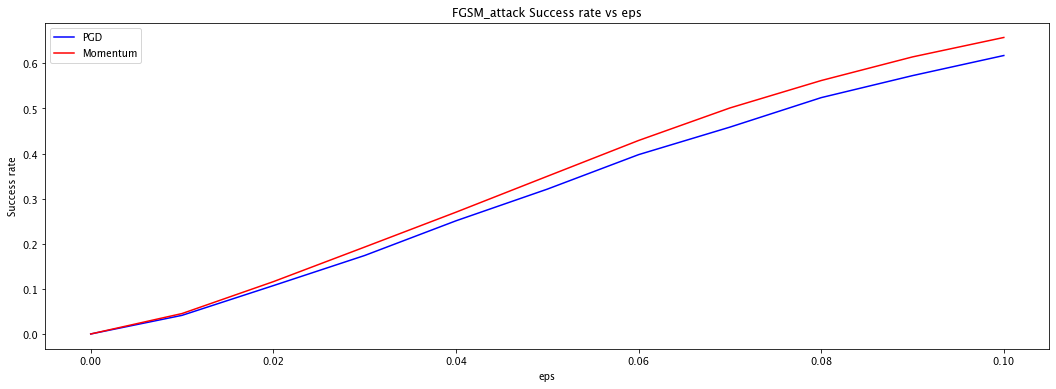

In [16]:
plt.figure(figsize=(18,6))
plt.title("FGSM_attack Success rate vs eps")
plt.plot(epslist,btest_acc*np.ones(len(bbaccPGD))-bbaccPGD, color='b',label='PGD')
plt.plot(epslist,btest_acc*np.ones(len(bbaccMu))-bbaccMu, color='r',label='Momentum')

plt.xlabel('eps')
plt.ylabel("Success rate")
plt.legend()
plt.show()

In [ ]:
## Pick a model architecture

net = models.NetA().to(device)
# net = models.NetB().to(device)

## Checkpoint name for this model

model_checkpoint = "netA_advtrain_fgsm0p1.pt"
# model_checkpoint = "netB_standard.pt"

## Basic training params
E=0.1
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop

for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        # Forward pass
        adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps=E)
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.74410; TrainLoss: 0.65643; TestAcc: 0.45610; TestLoss: 3.62223
Epoch: [ 1 / 20 ]; TrainAcc: 0.85357; TrainLoss: 0.39432; TestAcc: 0.50420; TestLoss: 2.32010
Epoch: [ 2 / 20 ]; TrainAcc: 0.91147; TrainLoss: 0.24739; TestAcc: 0.67750; TestLoss: 1.21073
Epoch: [ 3 / 20 ]; TrainAcc: 0.92082; TrainLoss: 0.22225; TestAcc: 0.53130; TestLoss: 3.05226
Epoch: [ 4 / 20 ]; TrainAcc: 0.92898; TrainLoss: 0.20454; TestAcc: 0.49070; TestLoss: 4.17796
Epoch: [ 5 / 20 ]; TrainAcc: 0.92267; TrainLoss: 0.22404; TestAcc: 0.59690; TestLoss: 1.54274
Epoch: [ 6 / 20 ]; TrainAcc: 0.94470; TrainLoss: 0.16359; TestAcc: 0.66520; TestLoss: 1.30630
Epoch: [ 7 / 20 ]; TrainAcc: 0.95602; TrainLoss: 0.13248; TestAcc: 0.61730; TestLoss: 1.49982
Epoch: [ 8 / 20 ]; TrainAcc: 0.92685; TrainLoss: 0.21106; TestAcc: 0.76260; TestLoss: 0.66785
Epoch: [ 9 / 20 ]; TrainAcc: 0.95633; TrainLoss: 0.13089; TestAcc: 0.63560; TestLoss: 1.22250
Epoch: [ 10 / 20 ]; TrainAcc: 0.97162; TrainLoss: 0.08879; T

## Test Robust Models

In [ ]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

## Test the model against an adversarial attack

# TODO: Set attack parameters here
#ATK_EPS = ?
#ATK_ITERS = ?
#ATK_ALPHA = ?

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    # TODO: Perform adversarial attack here
    
    # Sanity checking if adversarial example is "legal"
    assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
    assert(adv_data.max() == 1.)
    assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(adv_data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)
    
    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(12):
            plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

# Print final 
whitebox_acc = whitebox_correct/running_total
print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")